In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
import torch
from torch import nn, distributions
from torch import optim
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
from sklearn.datasets import load_iris
from scipy.stats import gaussian_kde


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device.type.upper()}")

rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 100

Running on CUDA


In [3]:
class RealNVPBlock(nn.Module):
    def __init__(self, in_features, hidden_features):
        super(RealNVPBlock, self).__init__()
        self.in_features = in_features
        self.hidden_features = hidden_features

        self.net_s = self._build_network()
        self.net_t = self._build_network()

    def _build_network(self):
        return nn.Sequential(
            nn.Linear(self.in_features // 2, self.hidden_features),
            nn.ReLU(),
            nn.Linear(self.hidden_features, self.hidden_features * 2),
            nn.ReLU(),
            nn.Linear(self.hidden_features * 2, self.hidden_features * 2),
            nn.ReLU(),
            nn.Linear(self.hidden_features * 2, self.hidden_features),
            nn.ReLU(),
            nn.Linear(self.hidden_features, self.in_features // 2),
        )

    def forward(self, x):
        x_a, x_b = x.chunk(2, dim=1)
        s = self.net_s(x_a)
        t = self.net_t(x_a)
        y_a = x_a
        y_b = x_b * torch.exp(s) + t
        log_det_jacobian = s.sum(dim=1)
        return torch.cat([y_a, y_b], dim=1), log_det_jacobian

    def backward(self, y):
        y_a, y_b = y.chunk(2, dim=1)
        s = self.net_s(y_a)
        t = self.net_t(y_a)
        x_a = y_a
        x_b = (y_b - t) * torch.exp(-s)
        return torch.cat([x_a, x_b], dim=1)

In [4]:
class RealNVP(nn.Module):
    def __init__(self, num_blocks, in_features, hidden_features):
        super(RealNVP, self).__init__()
        self.blocks = nn.ModuleList([RealNVPBlock(in_features, hidden_features) for _ in range(num_blocks)])
        self.prior = distributions.MultivariateNormal(torch.zeros(in_features).to(device), torch.eye(in_features).to(device))

    def forward(self, x):
        log_det_jacobian = 0
        for block in self.blocks:
            x, ldj = block.forward(x)
            log_det_jacobian += ldj
            x = torch.flip(x, dims=(1,))
        return x, log_det_jacobian

    def backward(self, y):
        for block in reversed(self.blocks):
            y = torch.flip(y, dims=(1,))
            y = block.backward(y)
        return y

    def log_prob(self, x):
        y, log_det_jacobian = self.forward(x)
        log_prob_z = self.prior.log_prob(y)
        return log_prob_z + log_det_jacobian

    def sample(self, batch_size):
        y = self.prior.sample((batch_size,))
        x = self.backward(y)
        return x

In [5]:
def check_for_nan(tensor, name=""):
    if torch.isnan(tensor).any():
        print(f"NaN detected in {name}")
        return True
    return False

In [6]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)


class CustomDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [7]:
def plot_samples(samples, title, dim=2):
    samples = samples.detach().numpy()
    if dim == 2:
        plt.figure(figsize=(8, 8))
        plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
        plt.title(title)
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.show()
    elif dim == 3:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], alpha=0.5)
        ax.set_title(title)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('x3')
        plt.show()

def plot_comparison(original_samples, generated_samples, title, dim=2):
    original_samples = original_samples.detach().numpy()
    generated_samples = generated_samples.detach().numpy()
    if dim == 2:
        plt.figure(figsize=(8, 8))
        plt.scatter(original_samples[:, 0], original_samples[:, 1], alpha=0.5, label='Original')
        plt.scatter(generated_samples[:, 0], generated_samples[:, 1], alpha=0.5, label='Generated')
        plt.title(title)
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.legend()
        plt.show()
    elif dim == 3:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(original_samples[:, 0], original_samples[:, 1], original_samples[:, 2], alpha=0.5, label='Original')
        ax.scatter(generated_samples[:, 0], generated_samples[:, 1], generated_samples[:, 2], alpha=0.5, label='Generated')
        ax.set_title(title)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('x3')
        ax.legend()
        plt.show()

In [8]:
def train_real_nvp(model, train_loader, val_loader, optimizer, scheduler, num_epochs, visualize_epochs, num_samples):
    best_val_loss = float('inf')
    best_model_weights = None
    train_loss = []
    val_loss = []
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        total_train_loss = 0
        
        for x in train_loader:
            x = x.to(device)
            optimizer.zero_grad()
            loss = -model.log_prob(x).mean()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_loss.append(avg_train_loss)
        
        # Validation loss calculation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x in val_loader:
                x = x.to(device)
                val_loss_batch = -model.log_prob(x).mean()
                total_val_loss += val_loss_batch.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_weights = model.state_dict().copy()

        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

        if epoch + 1 in visualize_epochs:
            with torch.no_grad():
                # Visualization of samples from learned distribution
                generated_samples = model.sample(num_samples).cpu()
                plot_samples(generated_samples[:, :3], f'Generated_Samples_at_Epoch_{epoch + 1}', dim=3)

    # Restore best model weights
    model.load_state_dict(best_model_weights)
    torch.save(model.state_dict(), "best_realnvp_model.pth")

    return train_loss, val_loss

  0%|          | 0/88 [00:00<?, ?it/s]

Epoch 1/88, Training Loss: 31.5420, Validation Loss: 22.6418


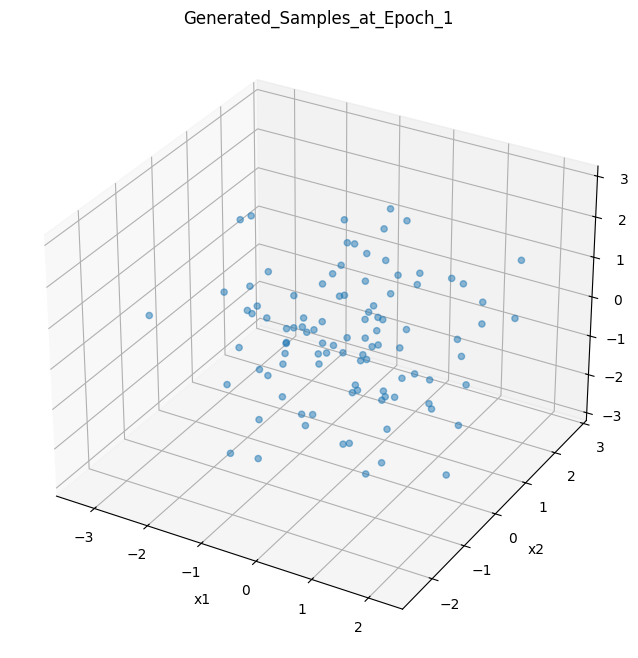

  1%|          | 1/88 [00:00<00:28,  3.06it/s]

Epoch 2/88, Training Loss: 21.8633, Validation Loss: 18.1925


  8%|▊         | 7/88 [00:00<00:05, 15.91it/s]

Epoch 3/88, Training Loss: 17.9294, Validation Loss: 15.3728
Epoch 4/88, Training Loss: 15.2906, Validation Loss: 13.6070
Epoch 5/88, Training Loss: 13.4576, Validation Loss: 12.7035
Epoch 6/88, Training Loss: 12.3786, Validation Loss: 11.8224
Epoch 7/88, Training Loss: 11.5023, Validation Loss: 10.9243
Epoch 8/88, Training Loss: 10.7139, Validation Loss: 10.1887


 15%|█▍        | 13/88 [00:00<00:03, 22.65it/s]

Epoch 9/88, Training Loss: 10.1013, Validation Loss: 9.6689
Epoch 10/88, Training Loss: 9.6390, Validation Loss: 9.2813
Epoch 11/88, Training Loss: 9.2208, Validation Loss: 8.9845
Epoch 12/88, Training Loss: 8.8521, Validation Loss: 8.7103
Epoch 13/88, Training Loss: 8.5354, Validation Loss: 8.4035
Epoch 14/88, Training Loss: 8.2401, Validation Loss: 8.1221


 23%|██▎       | 20/88 [00:00<00:02, 26.77it/s]

Epoch 15/88, Training Loss: 7.9871, Validation Loss: 7.9023
Epoch 16/88, Training Loss: 7.7658, Validation Loss: 7.7241
Epoch 17/88, Training Loss: 7.5567, Validation Loss: 7.5663
Epoch 18/88, Training Loss: 7.3598, Validation Loss: 7.3852
Epoch 19/88, Training Loss: 7.1621, Validation Loss: 7.1673
Epoch 20/88, Training Loss: 6.9536, Validation Loss: 6.9283
Epoch 21/88, Training Loss: 6.7328, Validation Loss: 6.6879


 31%|███       | 27/88 [00:01<00:02, 28.98it/s]

Epoch 22/88, Training Loss: 6.5024, Validation Loss: 6.4569
Epoch 23/88, Training Loss: 6.2671, Validation Loss: 6.2299
Epoch 24/88, Training Loss: 6.0289, Validation Loss: 5.9933
Epoch 25/88, Training Loss: 5.7904, Validation Loss: 5.7333
Epoch 26/88, Training Loss: 5.5471, Validation Loss: 5.4756
Epoch 27/88, Training Loss: 5.3056, Validation Loss: 5.2448
Epoch 28/88, Training Loss: 5.0685, Validation Loss: 5.0152


 35%|███▌      | 31/88 [00:01<00:01, 29.59it/s]

Epoch 29/88, Training Loss: 4.8366, Validation Loss: 4.7930
Epoch 30/88, Training Loss: 4.6094, Validation Loss: 4.5747
Epoch 31/88, Training Loss: 4.3889, Validation Loss: 4.3497
Epoch 32/88, Training Loss: 4.1993, Validation Loss: 4.2609
Epoch 33/88, Training Loss: 4.0317, Validation Loss: 4.0595
Epoch 34/88, Training Loss: 3.8729, Validation Loss: 3.9782


 40%|███▉      | 35/88 [00:01<00:01, 30.17it/s]

Epoch 35/88, Training Loss: 3.7494, Validation Loss: 3.7806


 44%|████▍     | 39/88 [00:01<00:01, 30.56it/s]

Epoch 36/88, Training Loss: 3.6841, Validation Loss: 3.7079
Epoch 37/88, Training Loss: 3.5404, Validation Loss: 4.2367
Epoch 38/88, Training Loss: 3.7635, Validation Loss: 4.2564
Epoch 39/88, Training Loss: 3.7379, Validation Loss: 3.5325
Epoch 40/88, Training Loss: 3.3415, Validation Loss: 3.7931
Epoch 41/88, Training Loss: 4.0468, Validation Loss: 4.1909
Epoch 42/88, Training Loss: 4.5012, Validation Loss: 3.5814


 53%|█████▎    | 47/88 [00:01<00:01, 31.20it/s]

Epoch 43/88, Training Loss: 3.7835, Validation Loss: 3.6286
Epoch 44/88, Training Loss: 3.4309, Validation Loss: 3.9994
Epoch 45/88, Training Loss: 3.5210, Validation Loss: 3.4432
Epoch 46/88, Training Loss: 3.1529, Validation Loss: 3.2013
Epoch 47/88, Training Loss: 3.3867, Validation Loss: 3.4442
Epoch 48/88, Training Loss: 3.6886, Validation Loss: 3.2641
Epoch 49/88, Training Loss: 3.2671, Validation Loss: 3.9544


 62%|██████▎   | 55/88 [00:02<00:01, 31.56it/s]

Epoch 50/88, Training Loss: 3.2852, Validation Loss: 4.2205
Epoch 51/88, Training Loss: 3.4148, Validation Loss: 3.3570
Epoch 52/88, Training Loss: 2.9999, Validation Loss: 3.0710
Epoch 53/88, Training Loss: 3.1399, Validation Loss: 3.2736
Epoch 54/88, Training Loss: 3.4004, Validation Loss: 3.0555
Epoch 55/88, Training Loss: 3.0742, Validation Loss: 3.2149
Epoch 56/88, Training Loss: 2.9383, Validation Loss: 3.3348


 67%|██████▋   | 59/88 [00:02<00:00, 29.90it/s]

Epoch 57/88, Training Loss: 2.9561, Validation Loss: 2.9566
Epoch 58/88, Training Loss: 2.7792, Validation Loss: 2.9494
Epoch 59/88, Training Loss: 3.0443, Validation Loss: 3.0672
Epoch 60/88, Training Loss: 3.2018, Validation Loss: 2.8178
Epoch 61/88, Training Loss: 2.8395, Validation Loss: 3.0014


 72%|███████▏  | 63/88 [00:02<00:00, 30.32it/s]

Epoch 62/88, Training Loss: 2.7077, Validation Loss: 3.2094
Epoch 63/88, Training Loss: 2.8119, Validation Loss: 2.8952


 76%|███████▌  | 67/88 [00:02<00:00, 30.68it/s]

Epoch 64/88, Training Loss: 2.6471, Validation Loss: 2.7528
Epoch 65/88, Training Loss: 2.7051, Validation Loss: 2.8146
Epoch 66/88, Training Loss: 2.7914, Validation Loss: 2.6624
Epoch 67/88, Training Loss: 2.5751, Validation Loss: 2.9632
Epoch 68/88, Training Loss: 2.6353, Validation Loss: 3.1848
Epoch 69/88, Training Loss: 2.7695, Validation Loss: 2.8170
Epoch 70/88, Training Loss: 2.5514, Validation Loss: 2.5537


 85%|████████▌ | 75/88 [00:02<00:00, 31.40it/s]

Epoch 71/88, Training Loss: 2.5170, Validation Loss: 2.6028
Epoch 72/88, Training Loss: 2.5946, Validation Loss: 2.5275
Epoch 73/88, Training Loss: 2.4352, Validation Loss: 2.8784
Epoch 74/88, Training Loss: 2.5528, Validation Loss: 3.0944
Epoch 75/88, Training Loss: 2.6738, Validation Loss: 2.7473
Epoch 76/88, Training Loss: 2.4391, Validation Loss: 2.5051
Epoch 77/88, Training Loss: 2.4027, Validation Loss: 2.5700


 90%|████████▉ | 79/88 [00:02<00:00, 31.31it/s]

Epoch 78/88, Training Loss: 2.5048, Validation Loss: 2.4538
Epoch 79/88, Training Loss: 2.3274, Validation Loss: 2.7387
Epoch 80/88, Training Loss: 2.3905, Validation Loss: 2.9269
Epoch 81/88, Training Loss: 2.5026, Validation Loss: 2.5930
Epoch 82/88, Training Loss: 2.2880, Validation Loss: 2.4034


 94%|█████████▍| 83/88 [00:03<00:00, 31.45it/s]

Epoch 83/88, Training Loss: 2.3229, Validation Loss: 2.4884
Epoch 84/88, Training Loss: 2.4514, Validation Loss: 2.3547


100%|██████████| 88/88 [00:03<00:00, 27.72it/s]

Epoch 85/88, Training Loss: 2.2365, Validation Loss: 2.6196
Epoch 86/88, Training Loss: 2.2617, Validation Loss: 2.8139
Epoch 87/88, Training Loss: 2.3672, Validation Loss: 2.4883
Epoch 88/88, Training Loss: 2.1606, Validation Loss: 2.3543


In [9]:
iris = load_iris()
data = iris.data
target_samples = torch.Tensor(data)

# Split the data into train (2/3) and validation + test (1/3)
train_size = int(2/3 * len(target_samples))
val_size = test_size = (len(target_samples) - train_size) // 2
train_dataset, val_dataset, test_dataset = random_split(target_samples, [train_size, val_size, test_size])

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

dim = target_samples.shape[1]  # Number of features/dimensions
num_blocks = 8  # Increased from 6
hidden_features = 256  # Increased from 128
learning_rate = 1e-4  # Lowered from 1e-4
num_epochs = 88 # Increased from 600
visualize_epochs = [1, 100, 200, 300, 500, 1000]

model = RealNVP(num_blocks, dim, hidden_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)

train_loss, val_loss = train_real_nvp(model, train_loader, val_loader, optimizer, scheduler, num_epochs, visualize_epochs, len(train_dataset))

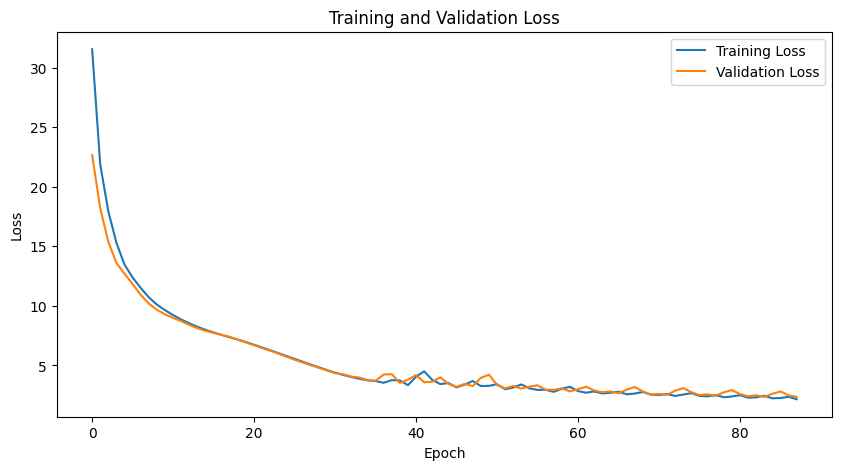

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

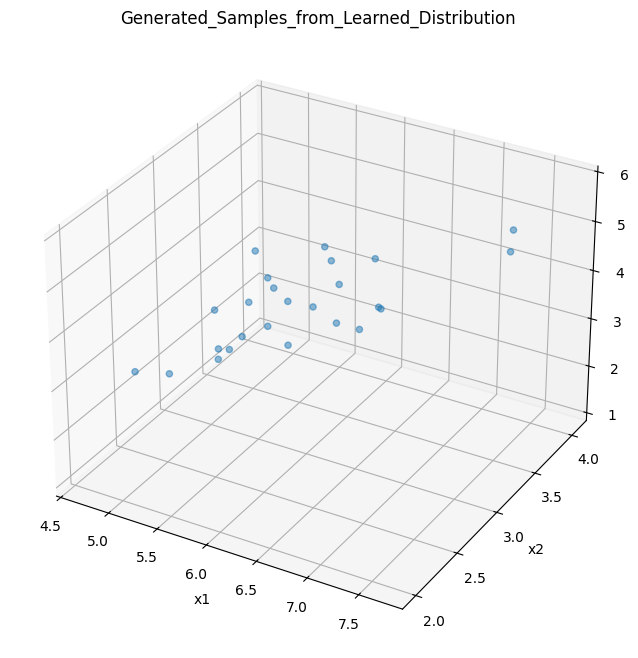

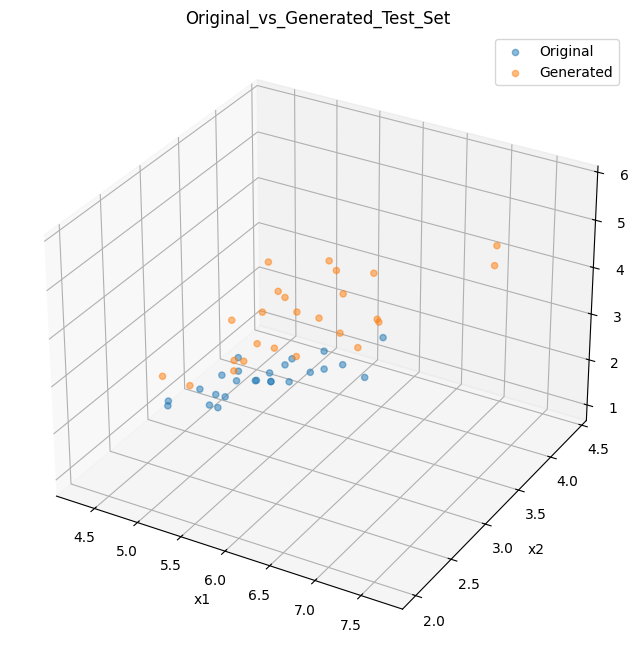

In [11]:
with torch.no_grad():
    generated_samples = model.sample(len(test_dataset)).cpu()
    plot_samples(generated_samples[:, :3], 'Generated_Samples_from_Learned_Distribution', dim=3)

# Plot comparison with original test set
plot_comparison(test_dataset.dataset[:len(test_dataset)][:, :3], generated_samples[:, :3], 'Original_vs_Generated_Test_Set', dim=3)

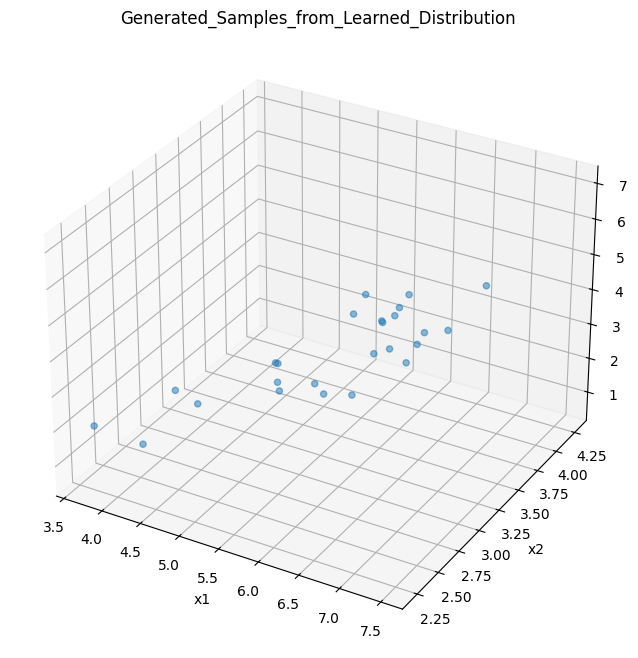

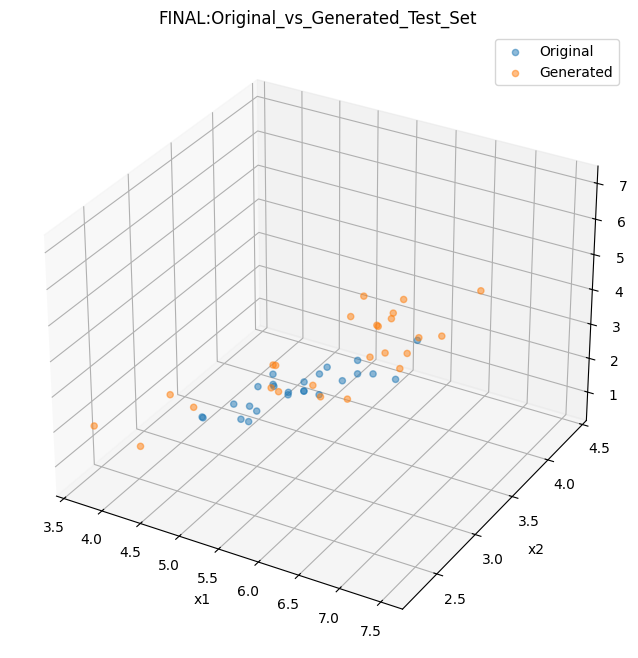

In [12]:
generated_samples = model.sample(len(test_dataset)).cpu()
plot_samples(generated_samples[:, :3], 'Generated_Samples_from_Learned_Distribution', dim=3)
plot_comparison(test_dataset.dataset[:len(test_dataset)][:, :3], generated_samples[:, :3], 'FINAL:Original_vs_Generated_Test_Set', dim=3)

In [13]:
def compute_data_overlap(original_samples, generated_samples, bandwidth='scott'):
    """
    Computes the probability of overlap between original and generated samples.

    Parameters:
    - original_samples (torch.Tensor): Tensor of original data samples.
    - generated_samples (torch.Tensor): Tensor of generated data samples.
    - bandwidth (str or float): The bandwidth of the kernel. 'scott' or 'silverman' can be used for automatic selection, or specify a float value.

    Returns:
    - overlap_probability (float): The computed probability of overlap between the original and generated samples.
    """
    # Convert samples to numpy for KDE
    original_samples_np = original_samples.detach().numpy().T
    generated_samples_np = generated_samples.detach().numpy().T

    # Ensure both arrays have the same number of samples by sampling the smaller set
    min_samples = min(original_samples_np.shape[1], generated_samples_np.shape[1])
    original_samples_np = original_samples_np[:, np.random.choice(original_samples_np.shape[1], min_samples, replace=False)]
    generated_samples_np = generated_samples_np[:, np.random.choice(generated_samples_np.shape[1], min_samples, replace=False)]

    # Create KDEs for both distributions
    kde_original = gaussian_kde(original_samples_np, bw_method=bandwidth)
    kde_generated = gaussian_kde(generated_samples_np, bw_method=bandwidth)

    # Evaluate the KDEs over the same grid
    sample_points = np.hstack([original_samples_np, generated_samples_np])

    original_density = kde_original(sample_points)
    generated_density = kde_generated(sample_points)

    # Compute overlap as the minimum density at each point
    overlap_density = np.minimum(original_density, generated_density)

    # Integrate the overlap density to get the total overlap probability
    overlap_probability = np.sum(overlap_density) / np.sum(kde_original(sample_points))

    return overlap_probability

In [14]:
model.eval()
with torch.no_grad():
    generated_samples = model.sample(len(test_dataset)).cpu()

    # Extract original samples from the test dataset and slice them to get only the first 2 dimensions
    original_samples = torch.stack([test_dataset[i] for i in range(len(test_dataset))])[:, :2]
    generated_samples = generated_samples[:, :2]

    overlap_probability = compute_data_overlap(original_samples, generated_samples)
    print(f"Final probability of data overlap: {overlap_probability:.4f}")

Final probability of data overlap: 0.7887
